It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/antoniotrapote/intro_deep_learning/blob/main/notebooks/RNN/Introduction_to_RNN_Time_Series.ipynb)
[![View on GitHub](https://img.shields.io/badge/View_on-GitHub-black?logo=github)](https://github.com/antoniotrapote/intro_deep_learning/blob/main/notebooks/RNN/Introduction_to_RNN_Time_Series.ipynb)



#### Import keras

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt

# Simple Architectures

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In time series forecasting we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [34]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [35]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 64)


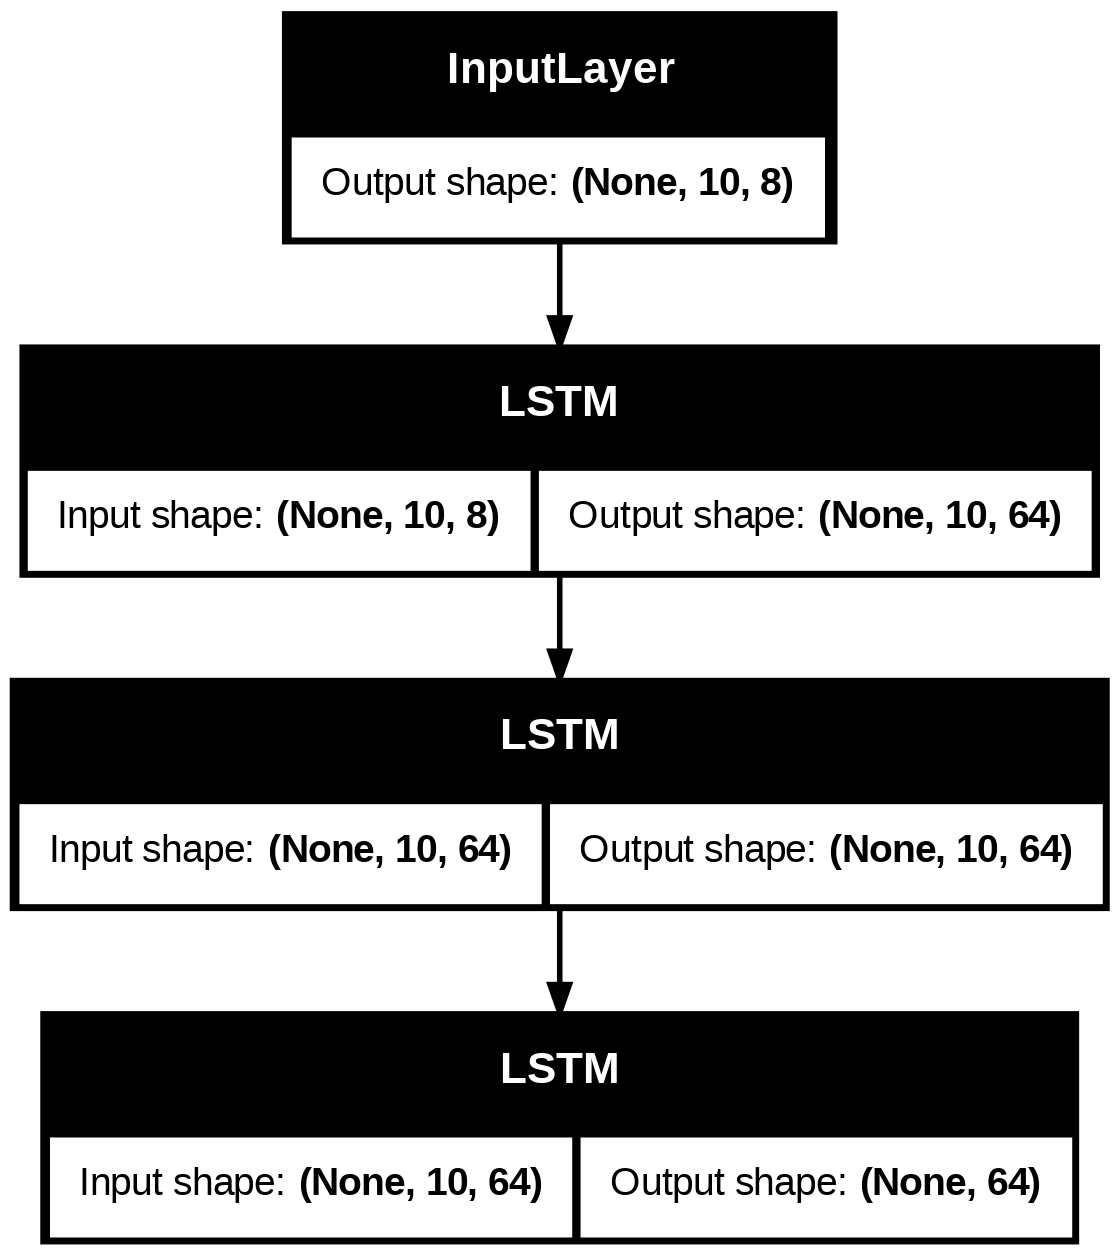

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [37]:
model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(timesteps, features))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(10))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,242 (309.54 KB)

 Trainable params: 79,242 (309.54 KB)

 Non-trainable params: 0 (0.00 B)

# Time Series Data Processing

## Sliding Windows

A sliding window is a technique used to create input-output pairs from time series data. It moves a fixed-size window over the time series data to extract subsequences as input features and the corresponding next value(s) as the target(s). The window size determines the number of past time steps to use as input features, and the horizon determines the number of future time steps to predict.


<img src="https://i.ibb.co/5nvJQB4/split-window.png" alt="cnn" border="0">

We will define two `create_windows` functions, one for `tf.data.Dataset` and another for NumPy, to create input-output pairs from the time series data using sliding windows.


For example if  `data = [0,1,2,3,4,5,6]` :

If we have `window_size=3`, and `horizon=2`, we use **windows of size 3** for predicting **2 steps ahead**.

we are going to use `[0,1,2] (length=window_size=3)` to predict `4`,

We need too create a training data like
```python
[0,1,2], 4
[1,2,3], 5
[2,3,4], 6
```


In [38]:
def create_windows_np(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray): Time series data with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Shuffle the windows or not.

    Returns:
    tuple: A tuple containing the input-output pairs (windows, targets) as NumPy arrays.
    """

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


In [39]:
X_trial, y_trial = create_windows_np(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)
for ind in range(len(y_trial)):
    print(X_trial[ind, :], y_trial[ind])

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


In [40]:
def create_windows_tf(data, window_size, horizon, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (np.ndarray): Time series data with with one dimension.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (window[:window_size], window[-1]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

ts_dataset = create_windows_tf(np.array([0, 1, 2, 3, 4, 5, 6]),
                                     window_size=3,
                                     horizon=2,
                                     shuffle=False)

for window, target in ts_dataset:
    print(window.numpy(), target.numpy())

[0 1 2] 4
[1 2 3] 5
[2 3 4] 6


# Simple univariate time series forecasting with RNN

We will use a sine wave as our example time series data. We will generate 1000 data points with a step of 0.1.

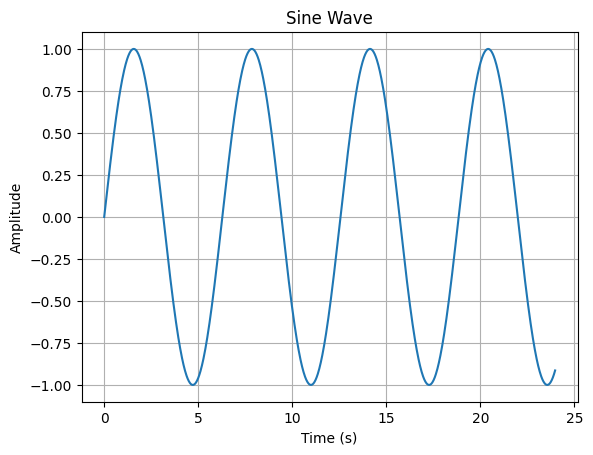

In [41]:
# Generate sine wave data
t = np.arange(0, 24, 0.02)
y = np.sin(t)

# Plot the sine wave
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sine Wave')
plt.grid(True)
plt.show()

In [42]:
# train test split
train_size = int(len(y) * 0.8)
ts_train, ts_test = y[:train_size], y[train_size:]
print(ts_test.shape)

(240,)


In [43]:
window_size = 10
horizon = 10
X_train, y_train = create_windows_np(ts_train, window_size, horizon=2, shuffle=True)
X_test, y_test = create_windows_np(ts_test, window_size, horizon=2, shuffle=False)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (949, 10)
Test shape: (229, 10)


In [44]:
inputs_shape = (window_size, 1)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, 1))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=7,
    validation_data=(X_test, y_test)
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.2684 - val_loss: 0.1562
Epoch 2/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0978 - val_loss: 0.0357
Epoch 3/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - val_loss: 0.0122
Epoch 4/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 5/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 6/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0091
Epoch 7/7
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0088


In [45]:
# Use the trained RNN model to make predictions on the test data.
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


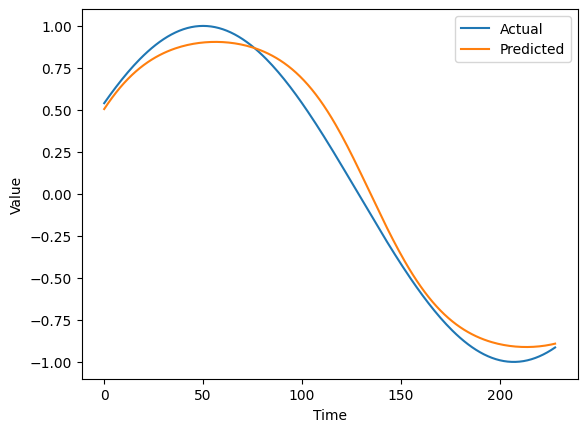

In [46]:
# visualize the actual vs. predicted values.
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Simple multivariate time series forecasting with RNNs

In [47]:
import pandas as pd


def create_windows_multivariate_np(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using NumPy.

    Parameters:
    data (np.ndarray or pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tuple: A tuple containing the input-output pairs (X, y) as NumPy arrays.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size+horizon-1, target_col_idx])

    X, y = np.array(X), np.array(y)

    if shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]

    return X, y


def create_windows_multivariate_tf(data, window_size, horizon, target_col_idx, shuffle=False):
    """
    Creates a dataset from the given time series data using tf.data.Dataset.

    Parameters:
    data (pd.DataFrame): Time series data with multiple features.
    window_size (int): The number of past time steps to use as input features.
    horizon (int): The number of future time steps to predict.
    target_col_idx (int): The index of the target column in the input data.
    shuffle (bool): Whether to shuffle the data or not.

    Returns:
    tf.data.Dataset: The resulting dataset.
    """
    if isinstance(data, pd.DataFrame):
        data = data.values

    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + horizon, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + horizon))
    ts_data = ts_data.map(lambda window: (
        window[:window_size], window[-1, target_col_idx]))
    if shuffle:
        ts_data = ts_data.shuffle(buffer_size=data.shape[0])
    return ts_data

In [48]:
# Generate synthetic multivariate time series data
t = np.arange(0, 24, 0.01)
y1 = np.sin(0.1 * t)
y2 = 0.5 * np.sin(0.2 * t)
data = np.vstack((y1, y2)).T
print(data.shape)

(2400, 2)


In [49]:
# train test split
train_size = int(data.shape[0] * 0.8)
ts_train, ts_test = data[:train_size], data[train_size:]
print(ts_test.shape)

(480, 2)


In [50]:
window_size = 10
horizon = 10


train_ds = create_windows_multivariate_tf(
    ts_train, window_size, horizon, target_col_idx=0, shuffle=True)

test_ds = create_windows_multivariate_tf(
    ts_test, window_size, horizon, target_col_idx=0, shuffle=False)

train_ds = train_ds.batch(64)
test_ds = test_ds.batch(100)

In [51]:
for window, target in train_ds:
    print(window.numpy().shape, target.numpy().shape)
    break

(64, 10, 2) (64,)


In [52]:
num_features = 2 # (y1, y2)

# Define input shape and number of time steps
inputs = keras.layers.Input(shape=(window_size, num_features))

# Define LSTM layer with a certain number of units
lstm_out_1 = keras.layers.LSTM(8, return_sequences=False)(inputs)

# Define output layer with a single unit
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    train_ds,
    epochs=12,
    validation_data=test_ds
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 8)              │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
     24/Unknown 1s 4ms/step - loss: 0.8412

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8102 - val_loss: 0.3015
Epoch 2/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3093 - val_loss: 0.0789
Epoch 3/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0393 - val_loss: 0.0112
Epoch 4/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0174 - val_loss: 0.0047
Epoch 5/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0120 - val_loss: 0.0010
Epoch 6/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 8.1972e-04
Epoch 7/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 7.1211e-04
Epoch 8/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 6.0435e-04
Epoch 9/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 6.8657e-04
Epoch 10/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033 - val_loss: 9.2948e-04
Epoch 11/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 12/12
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


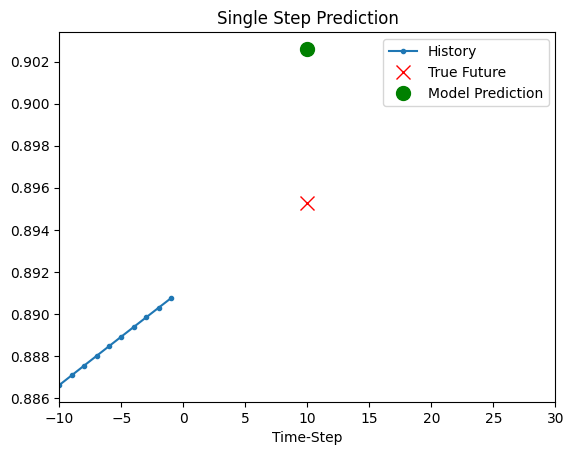

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


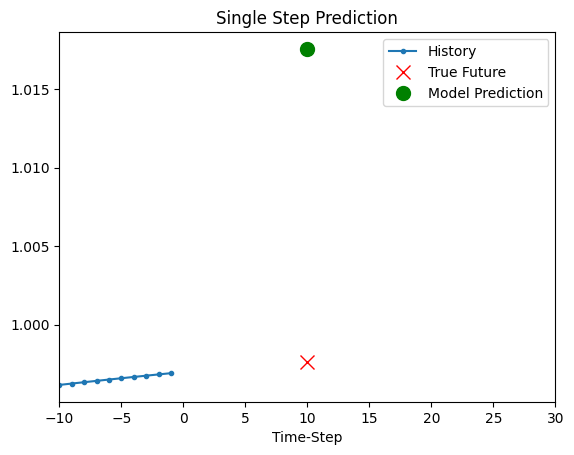

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


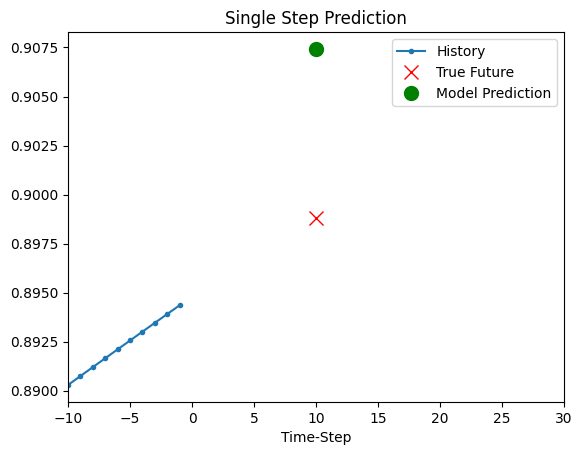

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


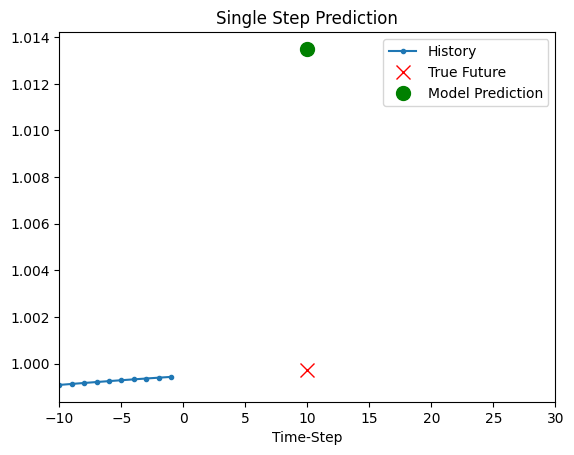

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


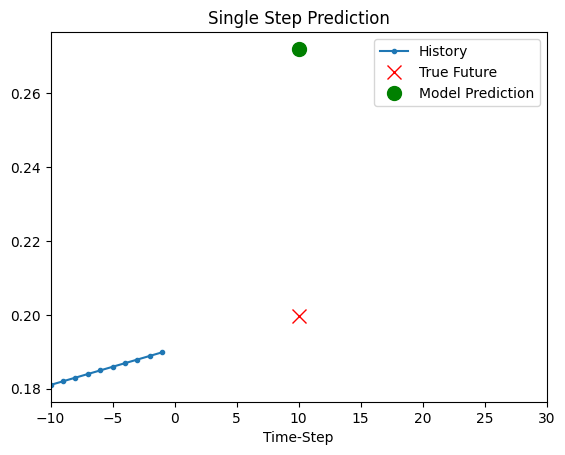

In [53]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in train_ds.take(5):
    x_in = x.numpy()
    y_in = y.numpy().flatten()
    pred = model.predict(x)
    show_plot(
        [x_in[0,:, 0], y_in[0], pred.flatten()[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


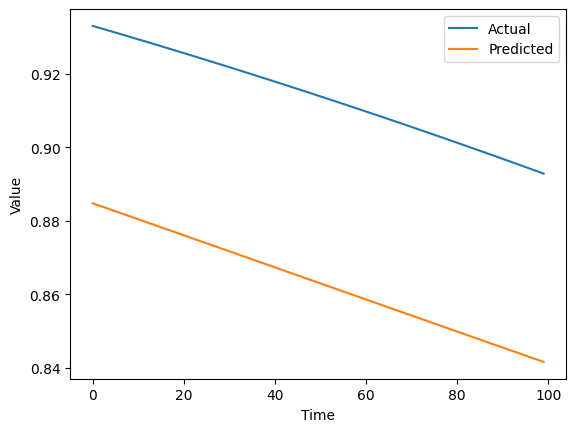

batch:  1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


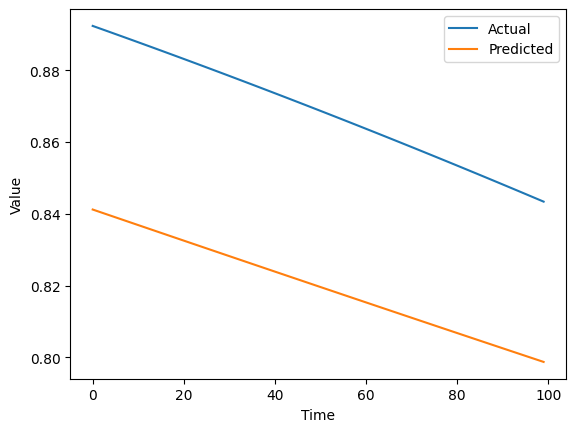

batch:  2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


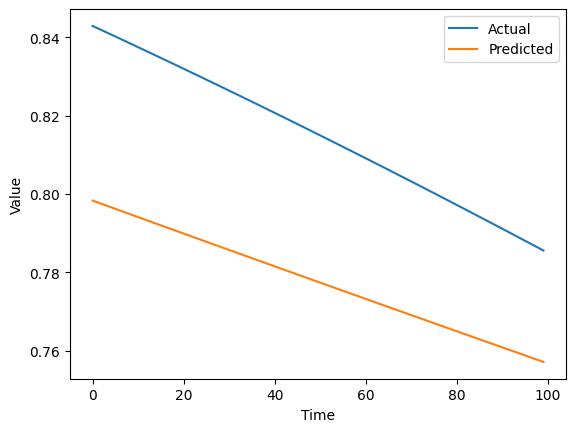

In [54]:
for i, (x, y) in enumerate(test_ds):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [55]:
from zipfile import ZipFile
import os
from datetime import datetime
import pandas as pd



uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()

def parse_dates(x):
    return datetime.strptime(x, '%d.%m.%Y %H:%M:%S')

csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, parse_dates=['Date Time'], date_format='%d.%m.%Y %H:%M:%S')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

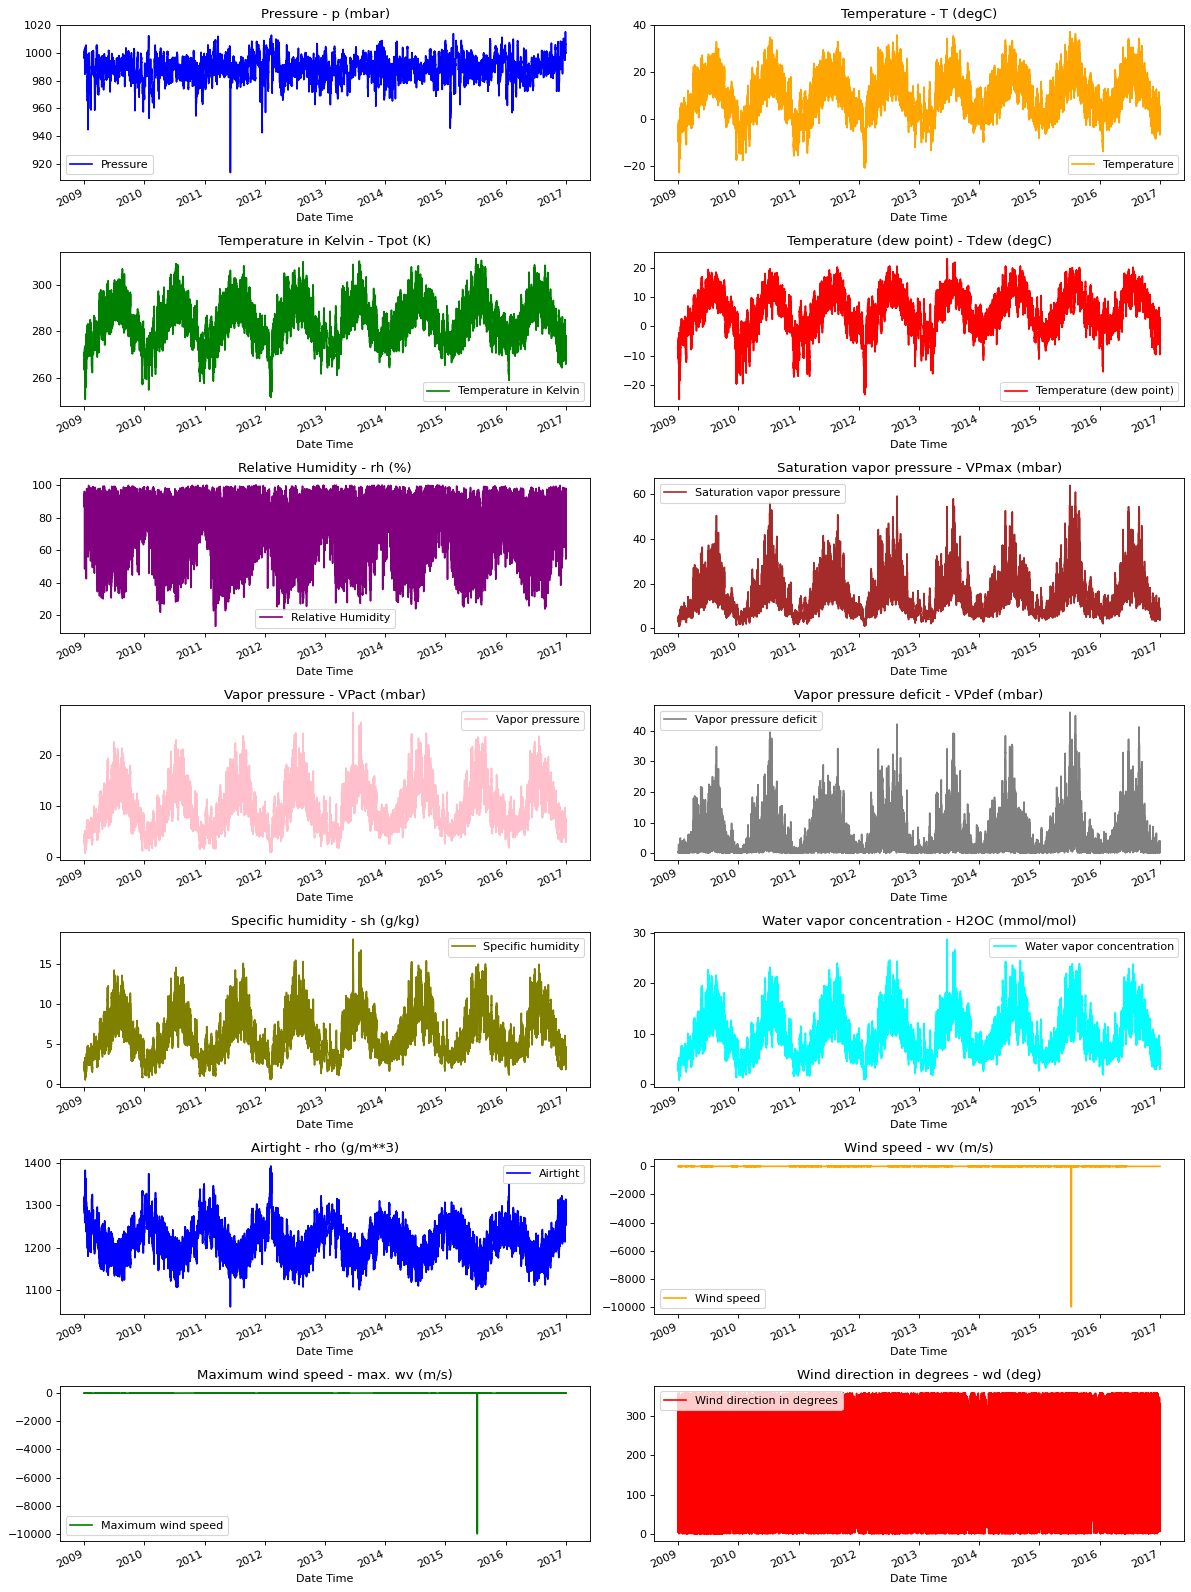

In [56]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

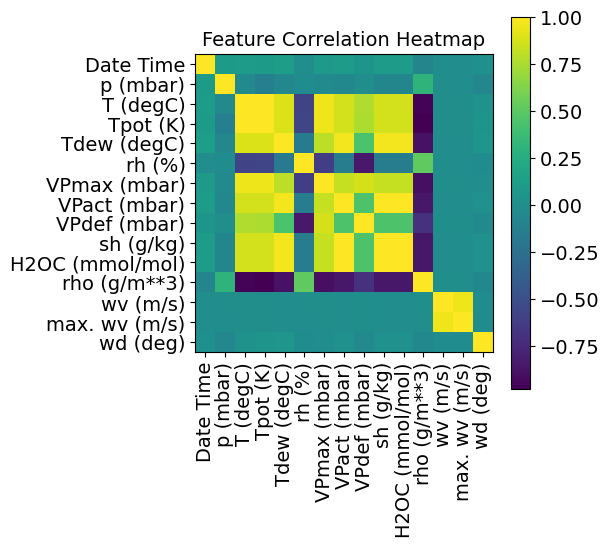

In [57]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [58]:
selected_features_title = ['Pressure', 'Temperature', 'Saturation vapor pressure',
                 'Vapor pressure deficit', 'Specific' 'humidity', 'Airtight', 'Wind speed']
selected_features = ['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)',
"max. wv (m/s)","wd (deg)" ]

### Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (76/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [59]:
df = df.set_index('Date Time')
## resample by the mean of hour values
df =df.resample('1h').mean().fillna(method='ffill') #
df.head()

<ipython-input-59-3551573031>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df =df.resample('1h').mean().fillna(method='ffill') #


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


In [60]:
#Use only important features
df_0 = df.copy()
df = df[selected_features].copy()

In [61]:
df.values.shape

(70129, 9)

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [62]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.290000,0.670000,150.093333


### Training and validation datasets



In [63]:
## previous hours to consider
window_size = 6
## Number of hours later to predict
horizon = 12

batch_size = 128

columns = df.columns
# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 9)
Target shape: (128,)


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [64]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Training

#### Normalization layer
We can normalize the features with [Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization).

```python
tf.keras.layers.experimental.preprocessing.Normalization(
    axis=-1, dtype=None, mean=None, variance=None, **kwargs
)
```

```python
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(dataset_train.map(lambda x, y: x))

```



`adapt` computes mean and std of the train data and store them as the layer's weights. `adapt`
 should be called before fit, evaluate, or predict.



In [65]:
norm = tf.keras.layers.Normalization(
    axis=-1, dtype=None, mean=None, variance=None
)
norm.adapt(dataset_train.map(lambda x, y: x))

print('Unnormalized row: ', df.iloc[:1].values)
print('Normalized row: ', norm(df.iloc[:1]))
print('Normalized df, mean row: ',norm(df.values).numpy().mean(1))
print('Normalized df, std row: ',np.std(norm(df.values).numpy(), 1))

Unnormalized row:  [[ 9.965280e+02 -8.304000e+00  3.260000e+00  2.020000e-01  1.910000e+00
   1.309196e+03  5.200000e-01  1.002000e+00  1.744600e+02]]
Normalized row:  tf.Tensor(
[[[ 0.9488956  -2.01424    -1.3145642  -0.7907289  -1.4998484
    2.2535071  -1.1247857  -1.1622002   0.01345587]]], shape=(1, 1, 9), dtype=float32)
Normalized df, mean row:  [[ 0.06747931  0.03871739  0.02784014  0.00901068  0.03926468 -0.02188004
  -0.31165653 -0.22941808  0.01771557]]
Normalized df, std row:  [[ 1.0075998  0.9727968  1.0055251  1.0171738  0.9927374  0.9756375
  42.949738  30.316557   0.98481  ]]


#### Create the model

In [66]:
#norm = tf.keras.layers.Normalization(axis=-1)
#norm.adapt(dataset_train.map(lambda x, y: x))

In [67]:
num_features =  9
inputs_shape = (window_size, num_features)

inputs = keras.layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)
rnn_out = keras.layers.SimpleRNN(32)(inputs_norm)
outputs = keras.layers.Dense(1)(rnn_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 6, 9)           │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,396 (5.46 KB)

 Trainable params: 1,377 (5.38 KB)

 Non-trainable params: 19 (80.00 B)

We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [68]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    365/Unknown 4s 4ms/step - loss: 92.2566

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 24.43565, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 90.2866 - val_loss: 24.4356
Epoch 2/25
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5381
Epoch 2: val_loss improved from 24.43565 to 18.33797, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.5173 - val_loss: 18.3380
Epoch 3/25
369/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.1067
Epoch 3: val_loss improved from 18.33797 to 16.76058, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.0844 - val_loss: 16.7606
Epoch 4/25
373/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.5574
Epoch 4: val_loss improved from 16.76058 to 16.48242, saving model to model_checkpoint.weights.h5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.5470 - val_loss: 16.4824
Epoch 5/25
369/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.6925
Epoch 5: val_loss improved from

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


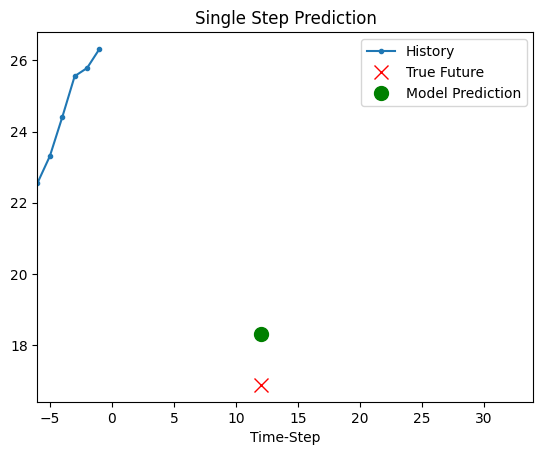

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


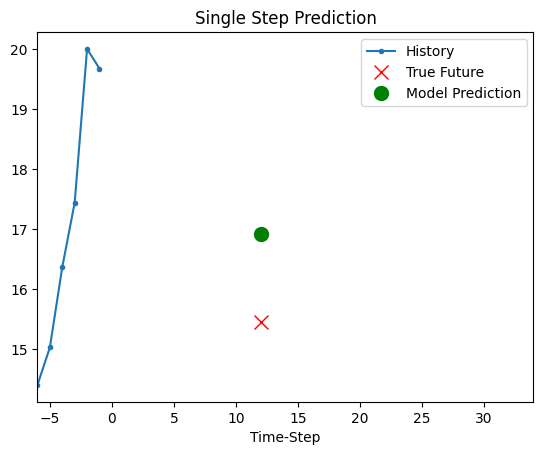

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


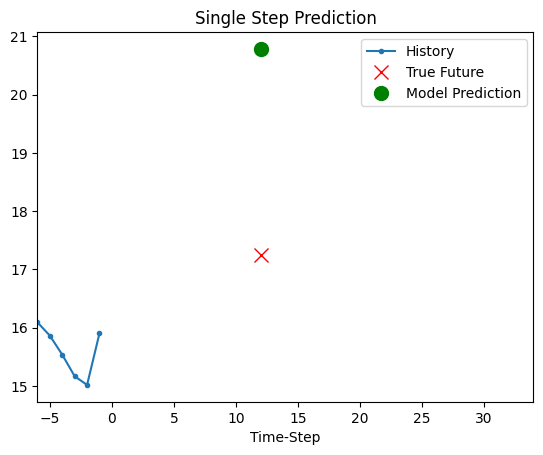

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


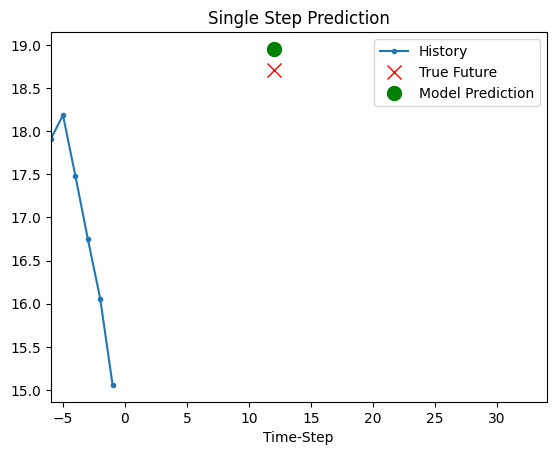

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


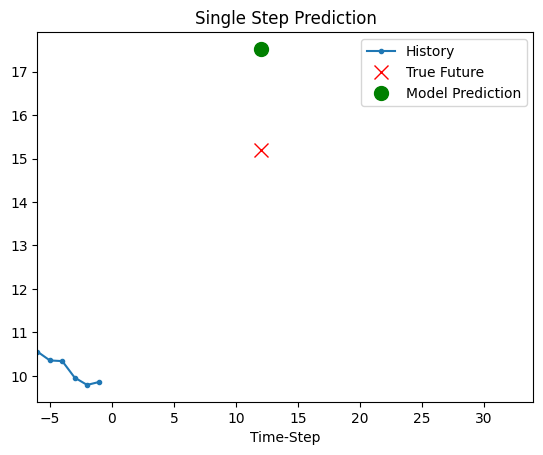

In [69]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


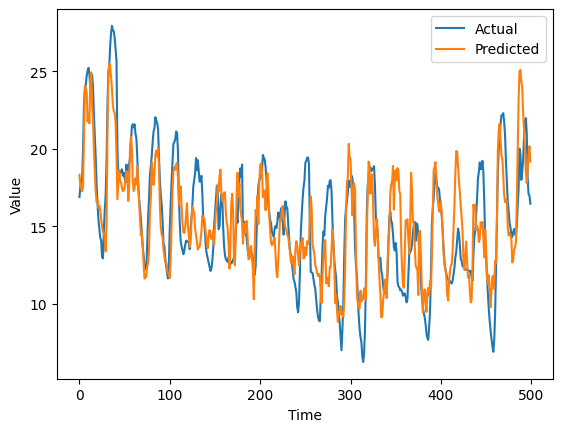

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


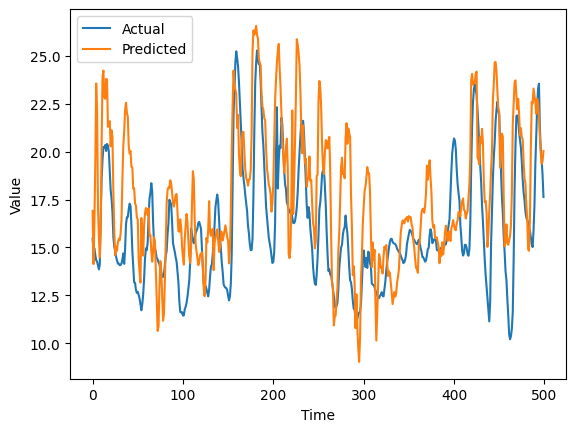

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


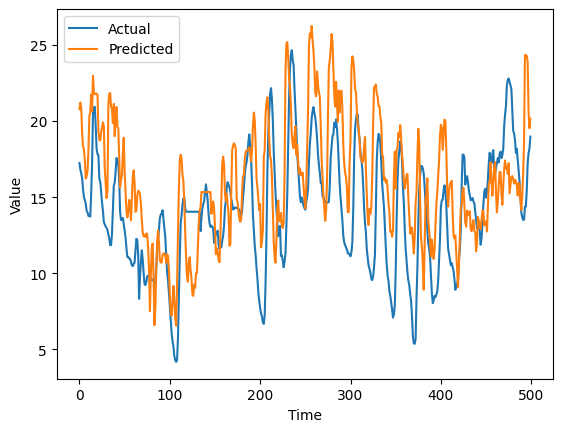

In [70]:

for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

#### Question 1:  Change the `keras.layers.SimpleRNN` layer to `keras.layers.LSTM` and to `keras.layers.GRU` and compare the results
You can also set the `recurrent_dropout` parameter

```python
tf.keras.layers.x(
    units,
    dropout=0.0,
    recurrent_dropout=0.0)
```

In [71]:
num_features = 9
inputs_shape = (window_size, num_features)

# Normalizacion de los features
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)


lstm_out = layers.GRU(64)(inputs_norm)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)


Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 61.9679 - val_loss: 16.9682
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.7468 - val_loss: 15.1344
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13.1578 - val_loss: 14.4528
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.7292 - val_loss: 13.9130
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12.2265 - val_loss: 15.4576
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 11.8911 - val_loss: 12.7602
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 11.5460 - val_loss: 12.7290
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 11.5400 - val_loss: 12.7848
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 11.1252 - val_loss: 12.0566
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 11.0130 - val_loss: 12.4751
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 10.6913 - val_loss: 12.3757
Epoch 12/25
384/384 ━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


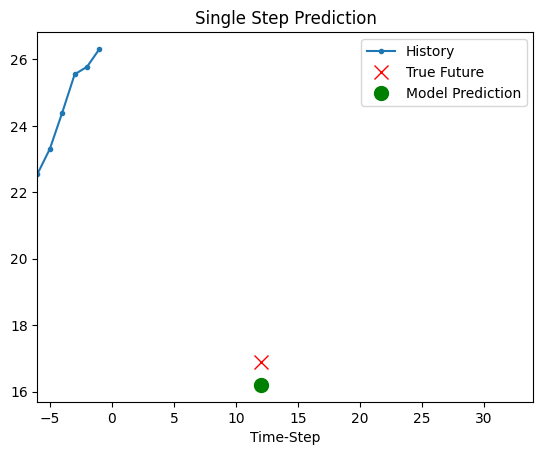

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


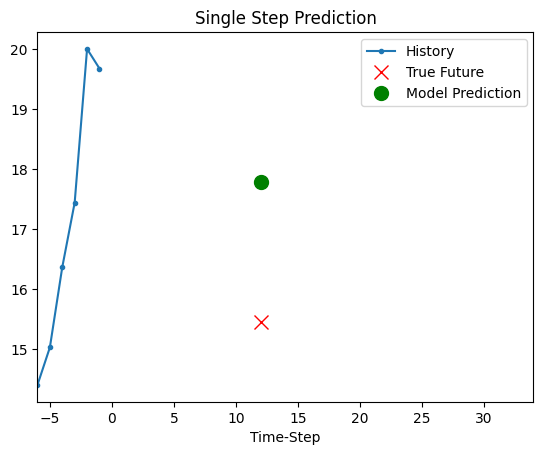

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


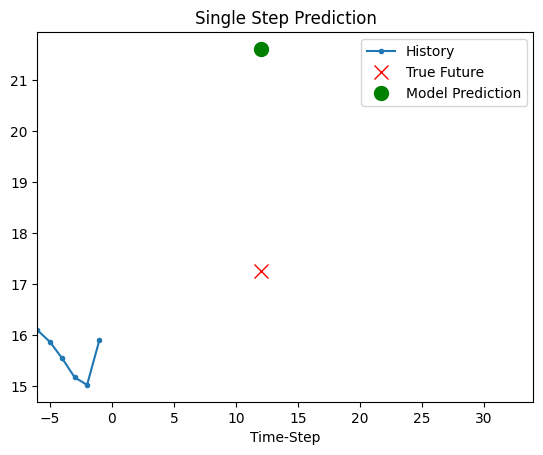

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


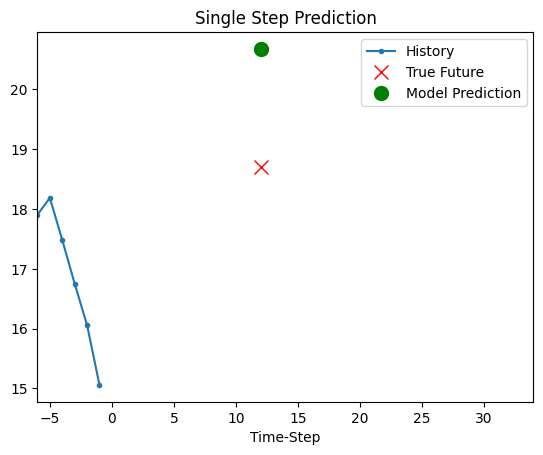

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


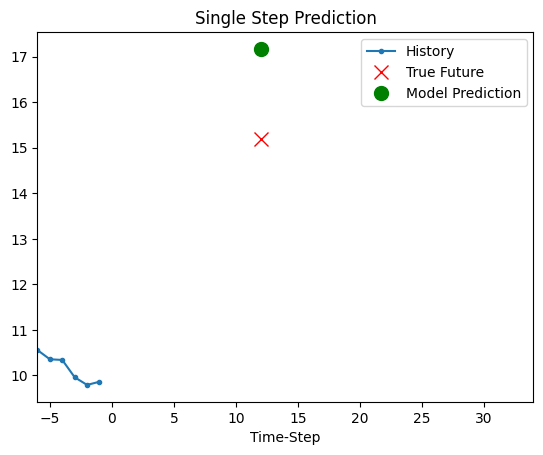

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


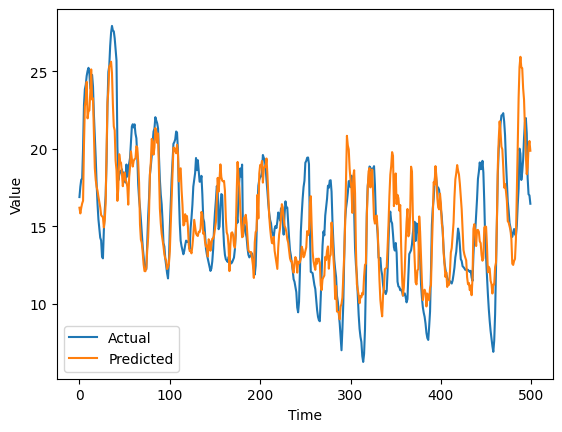

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


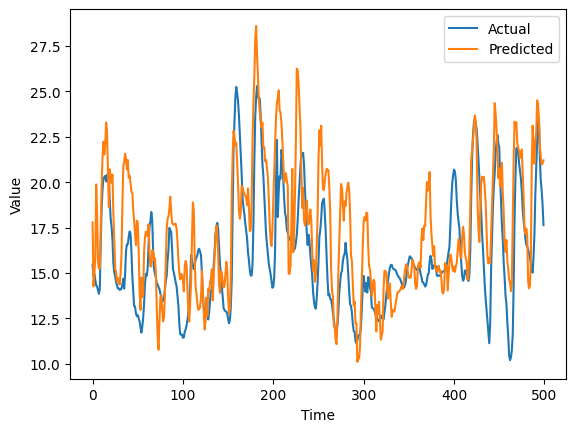

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


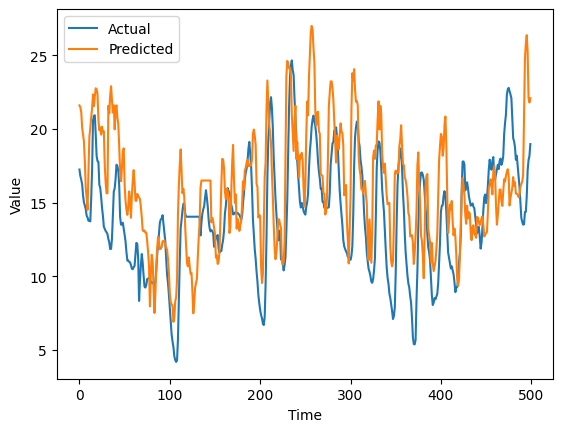

In [72]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )

for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Feature Engineering

Wind velocity
One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [73]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
df['wv (m/s)'] = wv

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
df['max. wv (m/s)'] = max_wv


But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [74]:
wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:


Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [75]:
from datetime import datetime
timestamp_s = df.index.map(datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [76]:
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [77]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

train_data = df.iloc[0 : train_split]
val_data = df.iloc[train_split:]
train_data.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,3.260000,0.202000,1.910000,1309.196000,1.002000,-0.517571,0.050201,-0.997320,0.096734,-1.776611e-12,1.000000,0.009332,0.999956
2009-01-01 01:00:00,996.525000,-8.065000,3.323333,0.201667,1.951667,1307.981667,0.711667,-0.313897,0.041790,-0.705442,0.093917,2.588190e-01,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.745000,-8.763333,3.145000,0.201667,1.836667,1311.816667,0.606667,-0.237713,-0.071845,-0.580723,-0.175515,5.000000e-01,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.986667,-8.896667,3.111667,0.210000,1.811667,1312.813333,0.606667,-0.162723,0.068793,-0.558784,0.236231,7.071068e-01,0.707107,0.011483,0.999934
2009-01-01 04:00:00,997.158333,-9.348333,3.001667,0.231667,1.733333,1315.355000,0.670000,-0.251383,0.144591,-0.580782,0.334054,8.660254e-01,0.500000,0.012199,0.999926


In [78]:
# Previous hours to consider
window_size = 6
# Number of hours later to predict
horizon = 12

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 15)
Target shape: (128,)


In [79]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

### Question 2:  Use the same model as before and compare the results


In [80]:
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(dataset_train.map(lambda x, y: x))

In [81]:

num_features = 15
inputs_shape = (window_size, num_features)

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

lstm_out = layers.GRU(64)(inputs_norm)
outputs = layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
    383/Unknown 3s 5ms/step - loss: 54.5009

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 54.3468 - val_loss: 8.2137
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.2993 - val_loss: 6.7018
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.3274 - val_loss: 6.3920
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.9701 - val_loss: 6.1324
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.7890 - val_loss: 6.1368
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.5809 - val_loss: 5.8499
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.5411 - val_loss: 5.8314
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.3182 - val_loss: 5.8422
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.3109 - val_loss: 5.9033
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.1899 - val_loss: 5.8761


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


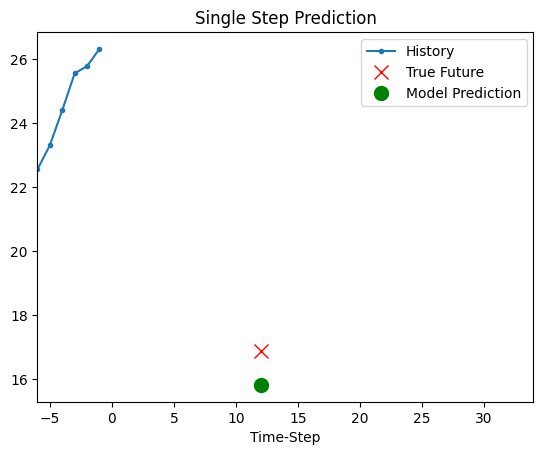

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


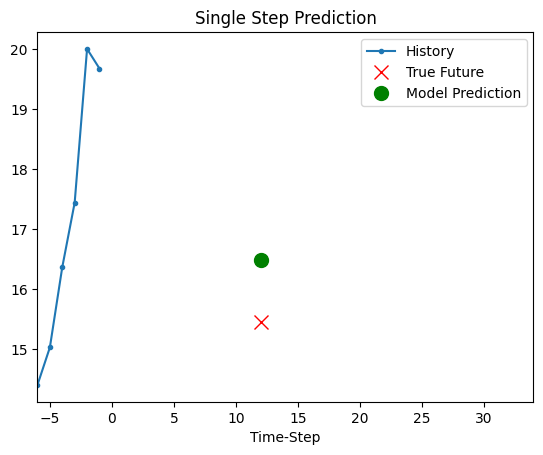

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


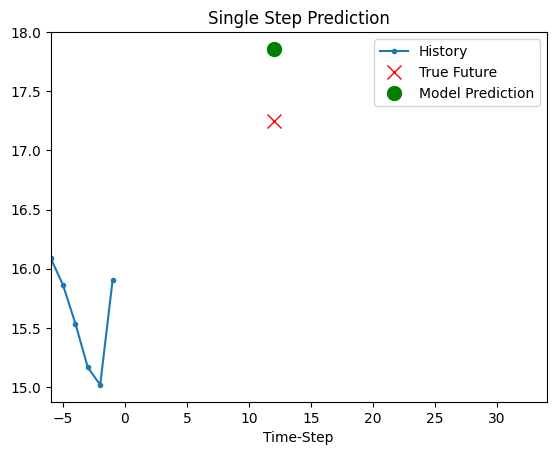

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


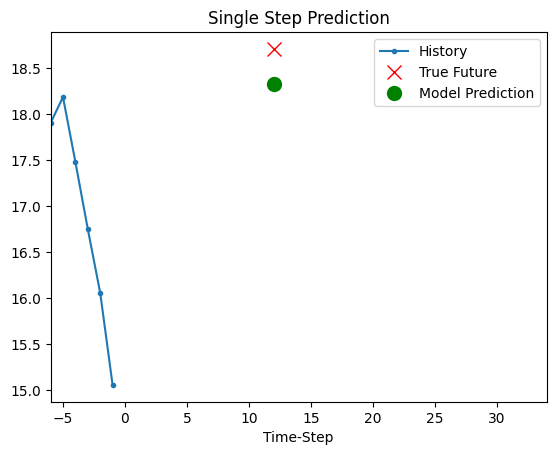

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


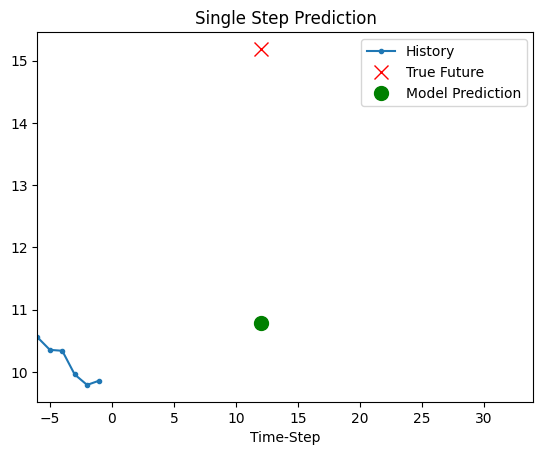

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


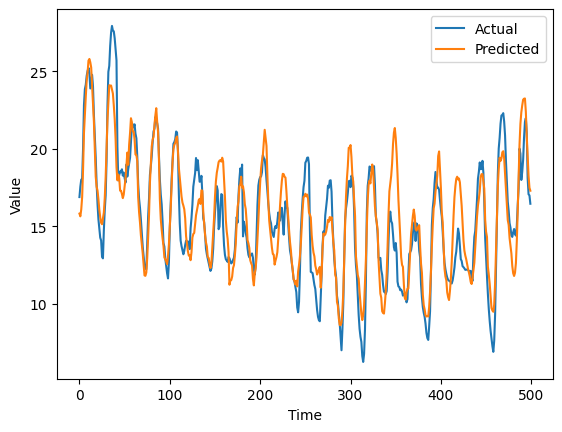

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


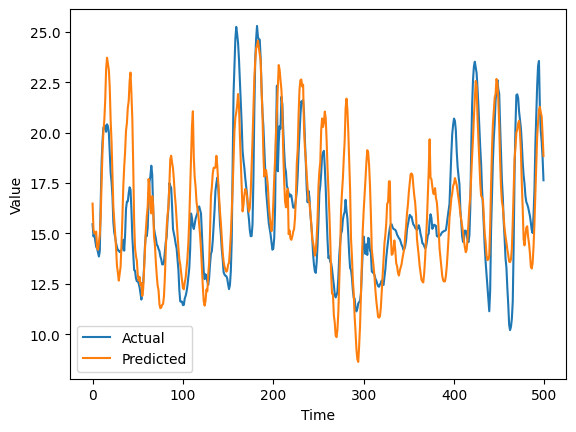

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


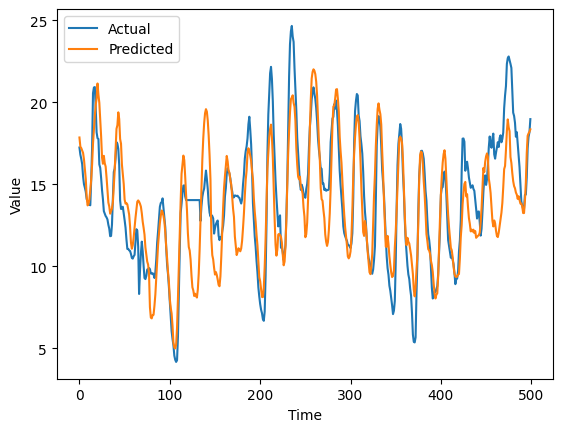

In [82]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )

for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 3:  Create a deep model stacking two recurrent layers

In [83]:
num_features = 15
inputs_shape = (window_size, num_features)


norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

inputs = layers.Input(shape=inputs_shape)
inputs_norm = norm(inputs)

l_1 = keras.layers.GRU(64, return_sequences=True)(inputs_norm)
l_2 = keras.layers.GRU(64, return_sequences=False)(l_1)

outputs = keras.layers.Dense(1)(l_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


In [84]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 47.6064 - val_loss: 7.7135
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 6.8608 - val_loss: 6.6469
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.0133 - val_loss: 6.2008
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.7295 - val_loss: 6.1208
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.4874 - val_loss: 5.6489
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.3047 - val_loss: 5.6741
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.1755 - val_loss: 5.6316
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0355 - val_loss: 5.7177
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0236 - val_loss: 5.6063
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.8156 - val_loss: 5.6454
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.7122 - val_loss: 5.5591
Epoch 12/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


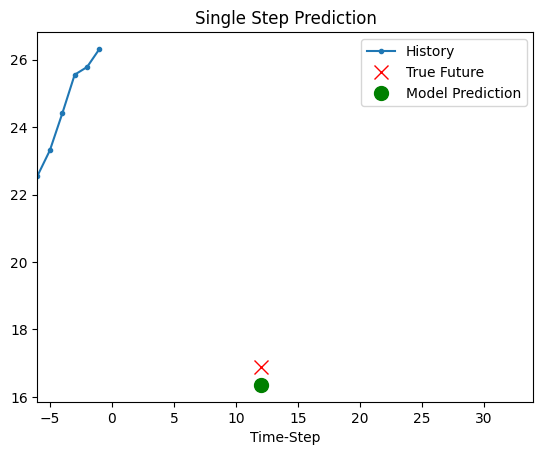

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


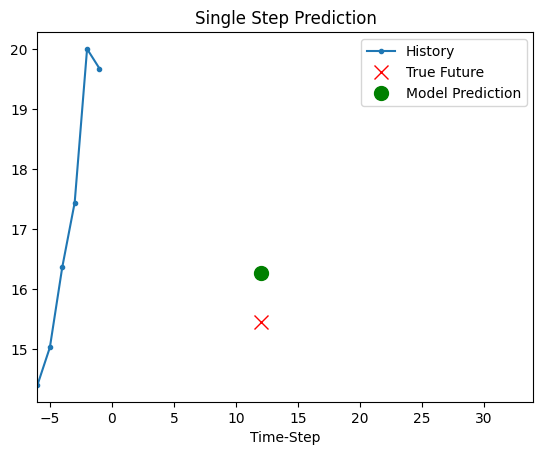

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


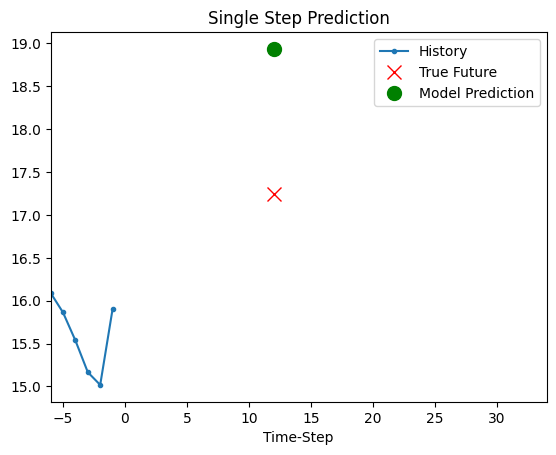

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


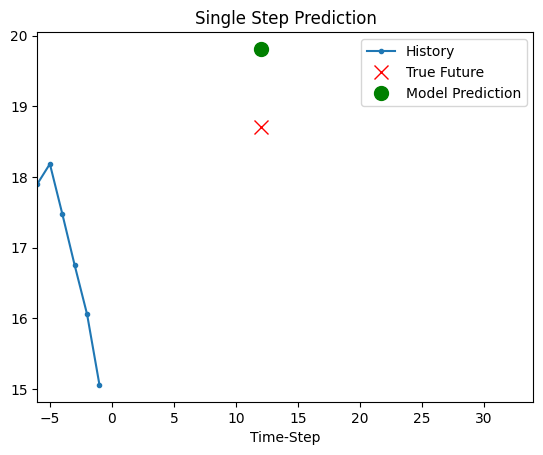

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


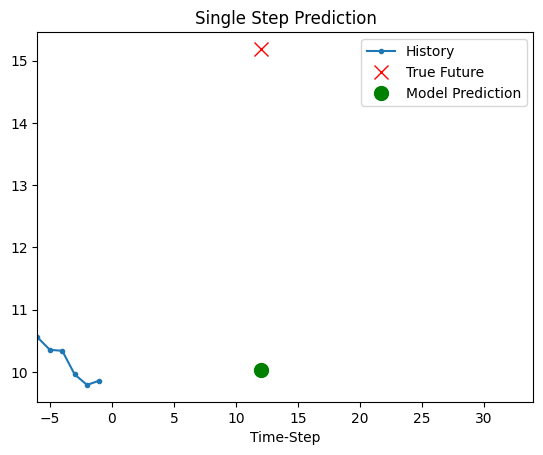

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


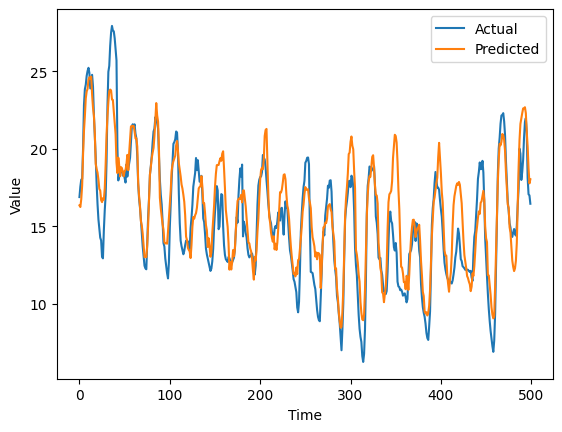

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


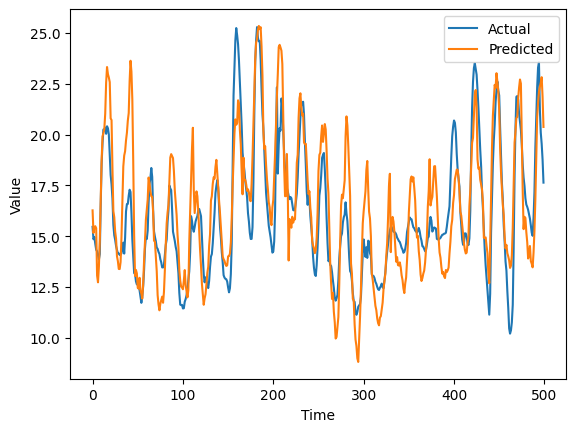

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


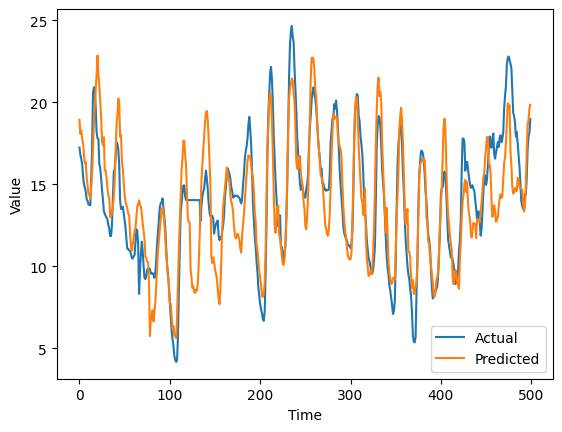

In [85]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Question 4:  Use `Bidirectional`  layer

```python
layers.Bidirectional(layers.LSTM(64, return_sequences=)
````


In [86]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))


inputs = layers.Input(shape=(window_size, num_features))
inputs_norm = norm(inputs)

l_1 = layers.Bidirectional(layers.GRU(64, return_sequences=False))(inputs_norm)

outputs = keras.layers.Dense(1)(l_1)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")


In [88]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 48.6272 - val_loss: 6.9461
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.7445 - val_loss: 6.3060
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.0537 - val_loss: 6.0799
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.7779 - val_loss: 5.8816
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.6207 - val_loss: 5.8868
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.3656 - val_loss: 5.8838
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.3099 - val_loss: 6.0627


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


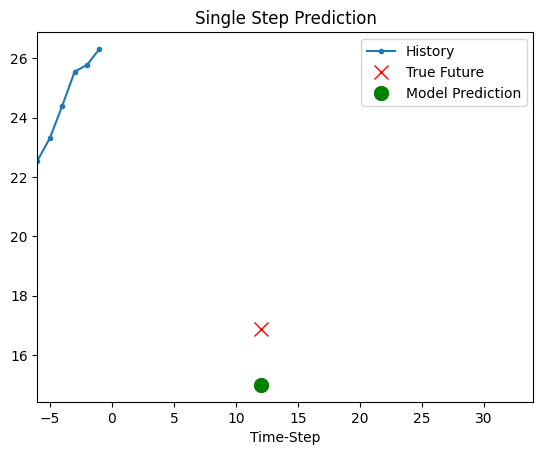

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


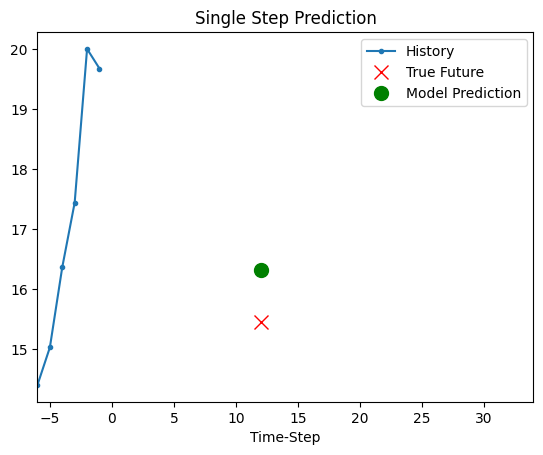

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


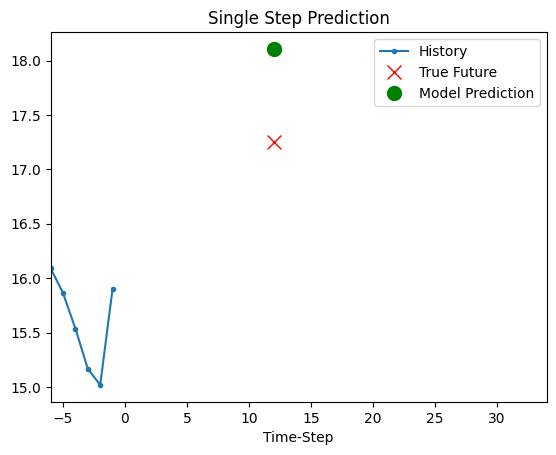

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


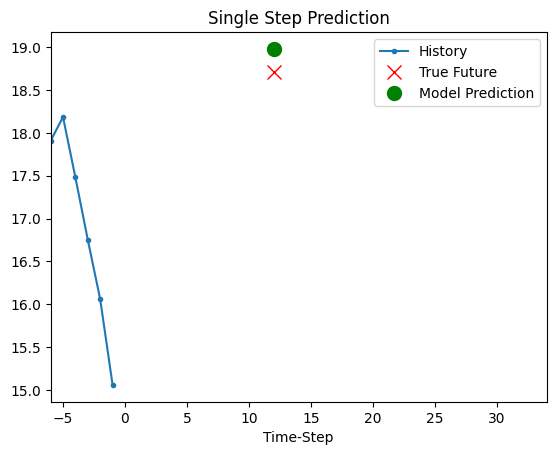

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


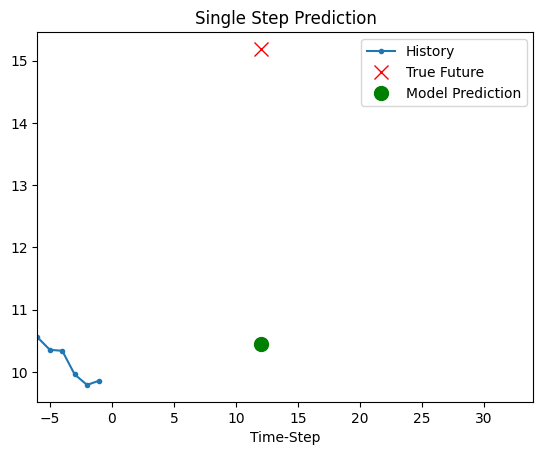

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


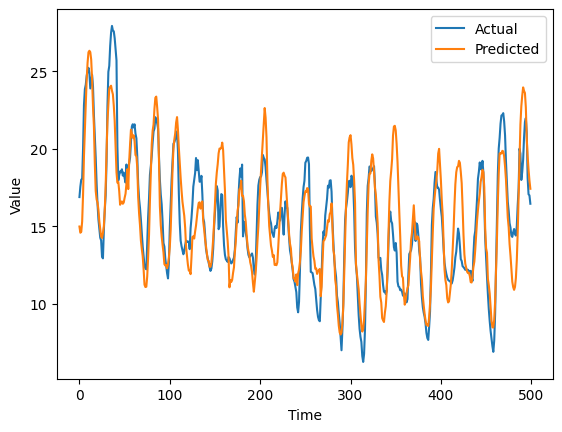

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


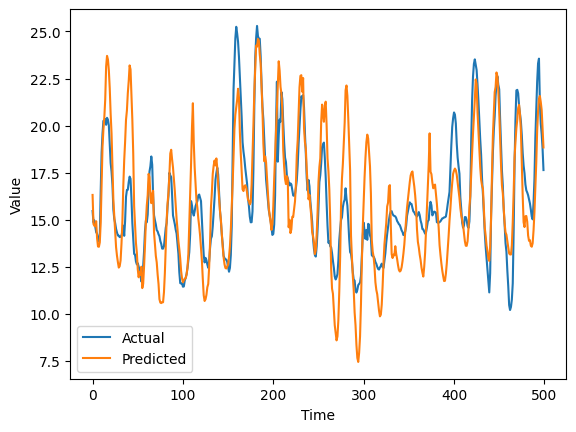

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


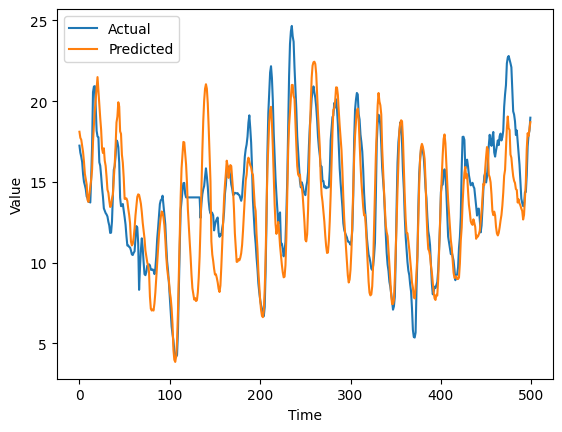

In [89]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

**Nota**: no tiene sentido usar una RNN bidireccional aquí, porque estarías introduciendo una información futura que en la práctica no tienes.

### Question 5:  Obtain a good model for predicting the temperature in 24h

Try different architectures and different values for `window_size`

In [123]:
horizon = 24

# Previous hours to consider
window_size = 48

batch_size = 128


# Get the target column index
target_col_idx = columns.get_loc('T (degC)')

dataset_train = create_windows_multivariate_tf(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)

dataset_val = create_windows_multivariate_tf(
    val_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

dataset_train = dataset_train.batch(batch_size)
dataset_val = dataset_val.batch(500)


for batch in dataset_train.take(1):
    inputs, targets = batch
    break

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 48, 15)
Target shape: (128,)


In [124]:
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

In [125]:
norm = tf.keras.layers.Normalization(
    axis=-1
)
norm.adapt(dataset_train.map(lambda x, y: x))

In [130]:
inputs = layers.Input(shape=(window_size, num_features))
inputs_norm = norm(inputs)


l_1 = keras.layers.GRU(128, return_sequences=True)(inputs_norm)
l_1 = layers.Dropout(0.4)(l_1)
l_2 = keras.layers.GRU(128, return_sequences=False)(l_1)
outputs = keras.layers.Dense(1)(l_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [131]:
path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
    381/Unknown 5s 9ms/step - loss: 32.5420

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 8.57902, saving model to model_checkpoint.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 32.4079 - val_loss: 8.5790
Epoch 2/25
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8968
Epoch 2: val_loss improved from 8.57902 to 8.15827, saving model to model_checkpoint.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.8954 - val_loss: 8.1583
Epoch 3/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2026
Epoch 3: val_loss improved from 8.15827 to 8.14673, saving model to model_checkpoint.weights.h5
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.2021 - val_loss: 8.1467
Epoch 4/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6934
Epoch 4: val_loss did not improve from 8.14673
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 7.6926 - val_loss: 8.3460
Epoch 5/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7678
Epoch 5: val_loss did not improve from 8.14673
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


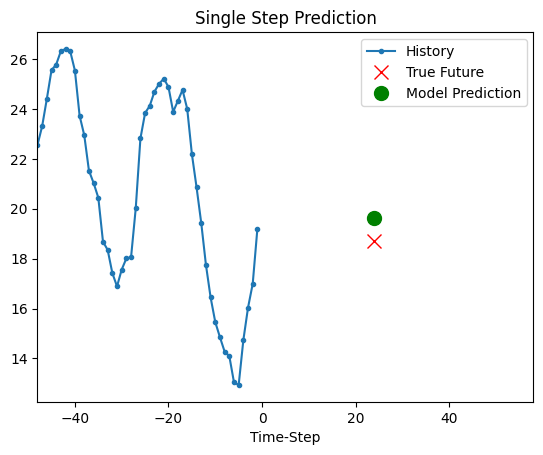

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


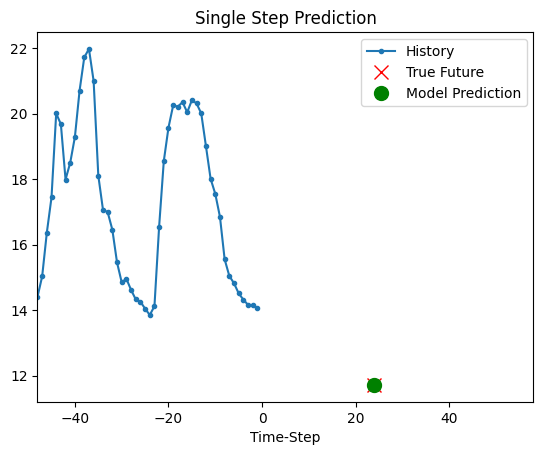

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


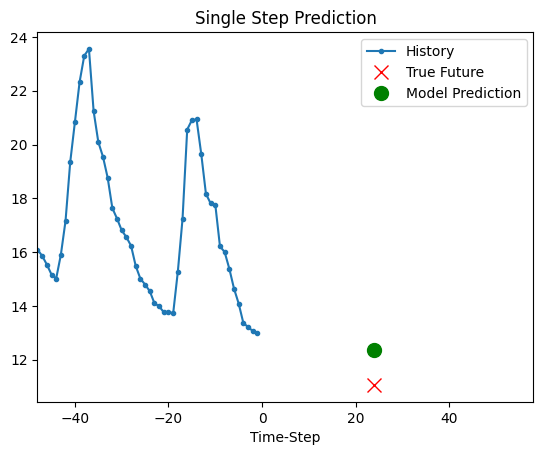

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


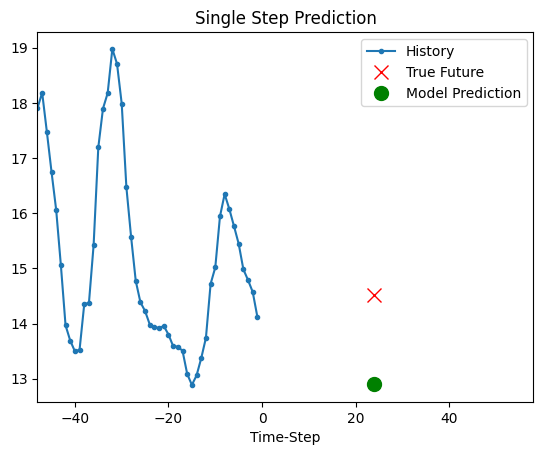

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


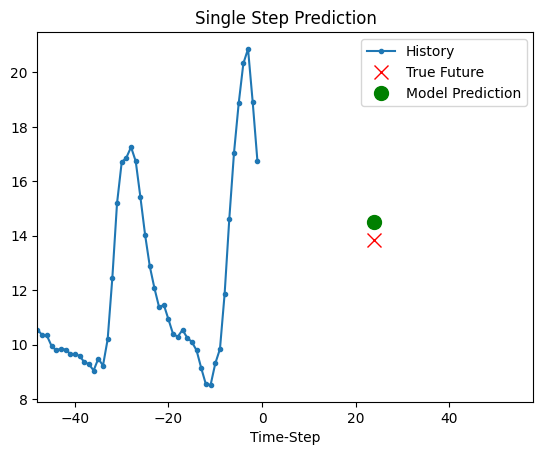

batch:  0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


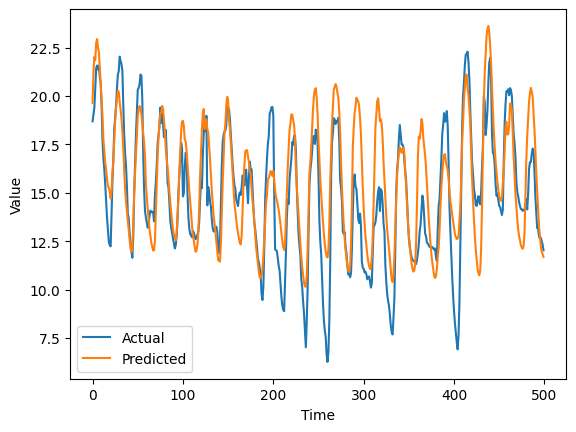

batch:  1
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


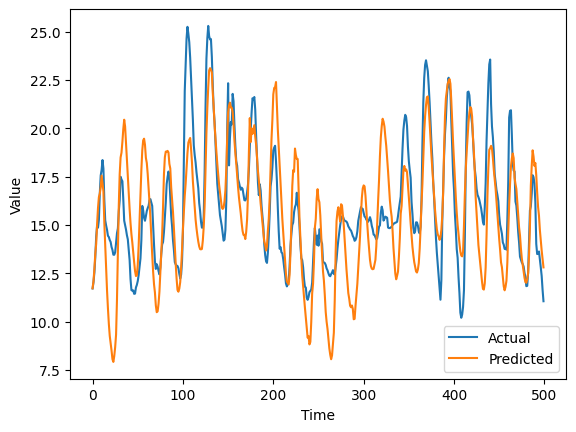

batch:  2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


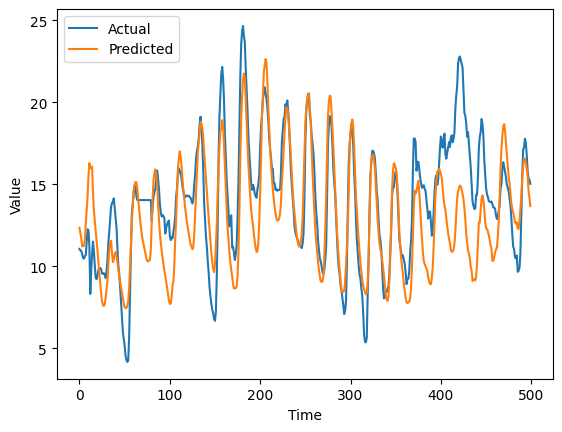

In [132]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        horizon,
        "Single Step Prediction",
    )



for i, (x, y) in enumerate(dataset_val):
    if i >= 3:
        break
    print('batch: ', i)
    y_pred = model.predict(x)
    plt.plot(y.numpy(), label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

## Practice: Cryptocurrency Forecasting

First of all, obtain and pre-process the data from [www.cryptodatadownload.com](www.cryptodatadownload.com)

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# http://www.cryptodatadownload.com/cdd/gemini_{0}USD_1hr.csv
# '../data/gemini_{0}USD_1hr.csv'
def get_coin_df(fpath='../data/gemini_{0}USD_1hr.csv'):
    coins = ['BTC', 'ETH', 'LTC', 'ZEC', 'DOGE']
    file_path = fpath.format('BTC')
    print(file_path)
    df = pd.read_csv(file_path, parse_dates=['date'], skiprows=1, skipfooter=1)
    df = df[['date', 'open']]
    df = df.set_index('date')
    df = df.sort_index()
    df = df.rename(columns={'open': 'BTC'})
    for coin in ['ETH', 'LTC', 'ZEC', 'DOGE']:
        coin_path = fpath.format(coin)
        df_coin = pd.read_csv(coin_path,
                              parse_dates=['date'],
                              skiprows=1,
                              skipfooter=1)
        df_coin = df_coin[['date', 'open']]
        df_coin = df_coin.set_index('date')
        df_coin = df_coin.sort_index()
        df_coin = df_coin.rename(columns={'open': coin})
        df[coin] = np.nan
        df.loc[df_coin.index, coin] = df_coin.values.flatten()
    return df


df = get_coin_df(
    fpath='http://www.cryptodatadownload.com/cdd/Gemini_{0}USD_1h.csv')
df.tail()

In [ ]:
# df = df.diff()
# df[df.columns] = np.sqrt(df.values)

Lets visualize the scaled values

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = scaler.fit_transform(df)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

In [ ]:
coins = ['BTC', 'ETH', 'LTC', 'ZEC']
for col in coins:
    df_normalized[col].plot(legend=True, figsize=(15, 7))
plt.ylabel('Dolars scaled')
plt.grid()
plt.show()

### Univariate Time Series
To start with, we will use only one cryptocurrency.

In [ ]:
coin_target = 'ETH' #  Coin that we want to predict, ['BTC', 'ETH', 'LTC', 'ZEC']
df_coin = df[coin_target].copy()
# delete nan rows
df_coin = df_coin.dropna()
df_coin.head()

In [ ]:
df_coin.plot(legend=True,figsize=(10,5))
plt.ylabel(coin_target)
plt.show()

In [ ]:
# Train-test split
test_date = pd.Timestamp("2023-01-10")
init_date = pd.Timestamp("2017-10-08 14:00:00")

# train_data = df_coin.loc[df_coin.index < test_date].values

train_data = df_coin.loc[(df_coin.index < test_date) *
                         (df_coin.index > init_date)].values

test_data = df_coin.loc[df_coin.index >= test_date].values

#### Data normalization

In [ ]:
mu = train_data.mean()
sigma = train_data.std()
print('mu, sigma: ', mu, sigma)

train_data = (train_data - mu) / sigma
test_data = (test_data - mu) / sigma

### Question 1: Create a model to predict the ETH value in 24h, `RMSE(test) < 50$`

In [ ]:
# Create windows
window_size, horizon = (6, 24)
X_train, y_train = create_windows_np(train_data, window_size, horizon, shuffle=True)
X_test, y_test = create_windows_np(test_data, window_size, horizon, shuffle=False)

In [ ]:
X_test[0, :], y_test[0], test_data[:window_size + horizon]

In [ ]:
from tensorflow.keras import layers
## Modify the initial model to obtain better results

inputs = keras.layers.Input(shape=(window_size, 1))

l_1 = layers.SimpleRNN(1, return_sequences=False) (inputs)
outputs = layers.Dense(1)(l_1)

model = keras.Model(inputs=inputs, outputs=outputs)




model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2, shuffle=True, batch_size = 64, callbacks=[es_callback]
)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(results))

In [ ]:
y_pred = model.predict(X_test).flatten() * sigma + mu
y_target = y_test * sigma + mu
diff = y_pred - y_target
print('max deviation: ', np.abs(y_pred - y_target).max())
print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
print('MAE: ', np.abs(y_pred - y_target).mean())

plt.figure(figsize=(12, 8))
plt.plot(y_target)
plt.plot(y_pred)
plt.legend(['True {0}'.format(coin_target), 'Predictions {0}'.format(coin_target)])
plt.show()

## Multivariate Time Series

In [ ]:
## You can try feature engineering with df
coin_target = 'ETH' # 'BTC'
coins =  ['ETH', 'LTC', 'ZEC', 'BTC'] # ['BTC', 'ETH', 'LTC', 'ZEC']
df_multi = df[coins].dropna()

In [ ]:
# You can create new features

## moving average features
for coin in coins:
    df_multi[coin+'_week_mu'] = df_multi[coin].rolling(window=7*24).mean()
    df_multi[coin+'_week_sigma'] = df_multi[coin].rolling(window=7*24).std()
df_multi = df_multi.dropna()

## time features
dt = df_multi.index.to_numpy()
dt = (dt - dt.min()) / np.timedelta64(24 * 365, 'h')
df_multi['time'] = dt

In [ ]:
train_data = df_multi.loc[(df_multi.index < test_date) * (df_multi.index > init_date ), : ].copy()
test_data = df_multi.loc[df_multi.index >= test_date, :].copy()

#### Normalize Data

In [ ]:
features = df_multi.columns
mu_dict = {}
sigma_dict = {}
for c in features:
    mu = train_data[c].mean()
    sigma = train_data[c].std()
    mu_dict[c] = mu
    sigma_dict[c] = sigma
    print('feature: {0} , mu,sigma'.format(c), mu, sigma)
print(mu_dict, sigma_dict)

In [ ]:
for c in features:
    mu = mu_dict[c]
    sigma = sigma_dict[c]
    train_data.loc[:, c] = (train_data[c].values - mu) / sigma
    test_data.loc[:, c] = (test_data[c].values - mu) / sigma
train_data.describe()

### Question 2: Create a model to predict the ETH value in 24h, `RMSE(test) < 50$`

In [ ]:
## Create windows
window_size, horizon = (..., 24)

columns = df_multi.columns
# Get the target column index
target_col_idx = columns.get_loc(coin_target)

X_train, y_train = create_windows_multivariate_np(
    train_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=True)
X_test, y_test = create_windows_multivariate_np(
    test_data, window_size, horizon, target_col_idx=target_col_idx, shuffle=False)

In [ ]:
X_train.shape, y_train.shape, X_test.shape

In [ ]:
from tensorflow.keras import layers

inputs = keras.layers.Input(shape=(window_size, len(features)))
...

outputs = layers.Dense(1)(...)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

model.summary()
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=8)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2, shuffle=True, batch_size = 64, callbacks=[es_callback]
)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(results))

In [ ]:
sigma = sigma_dict[coin_target]
mu = mu_dict[coin_target]
y_pred = model.predict(X_test).flatten() * sigma + mu
y_target = y_test * sigma + mu
diff = y_pred - y_target
print('max deviation: ', np.abs(y_pred - y_target).max())
print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
print('MAE: ', np.abs(y_pred - y_target).mean())

plt.figure(figsize=(12, 8))
plt.plot(y_target)
plt.plot(y_pred)
plt.legend(['True {0}'.format(coin_target), 'Predictions {0}'.format(coin_target)])
plt.show()

## Practice: Finance time series, SP500

In [ ]:
# Download yahoo finance library
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download the list of S&P 500 companies
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data = pd.read_html(sp500_url)
sp500_table = data[0]
sp500_tickers = sp500_table['Symbol'].tolist()

# Download hourly stock data for each company
start_date = '2022-01-01'
end_date = '2023-05-06'
interval = '1h'

data_dict = {}
for ticker in tqdm(sp500_tickers):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)
        data_dict[ticker] = stock_data['Close']
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")

# Create a DataFrame with every company in the columns
data_df = pd.DataFrame(data_dict)

In [ ]:
cols = ['MSFT', 'META', 'GOOGL', 'AMZN']
data_df[cols].plot(figsize=(15, 7), legend=False)
plt.title("S&P 500 Hourly Stock Data")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()


## References

https://www.tensorflow.org/guide/keras/rnn

https://keras.io/examples/timeseries/timeseries_weather_forecasting/